<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S10/blob/master/S10_Trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


In [2]:
!pip install -U git+https://github.com/albu/albumentations


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-z80hs2t5
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-z80hs2t5
     |████████████████████████████████| 634kB 49.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=80749bcd0bcf5b4ab19823616fa2659273a853f81ae5115770af49292245aa3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-43h6w0rv/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=36c35c3f3c1e33656fcb0b006865d3c1cd8834711b4ee35afdbb782b29e1a39f
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
 

In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session10'
sys.path.append(folder)

In [5]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import lr_finder

  pip install torch-lr-finder -v --global-option="amp"


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



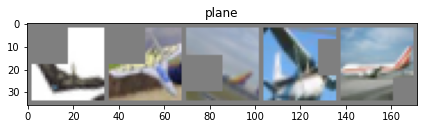

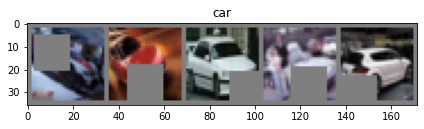

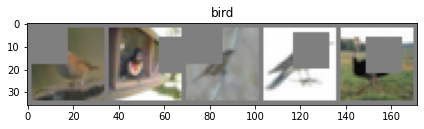

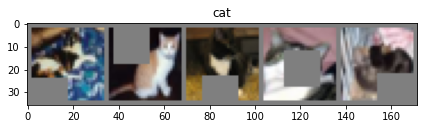

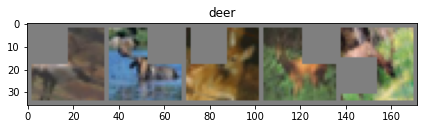

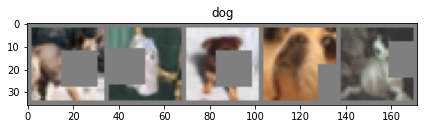

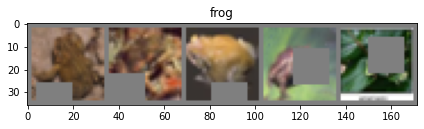

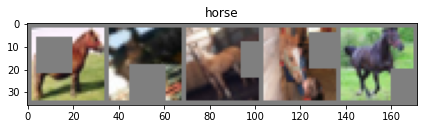

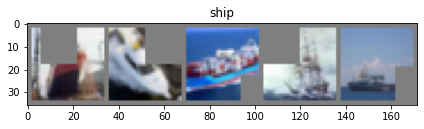

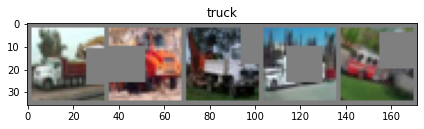

In [7]:
show_images.show_random_images(trainloader, classes)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(resnet.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
lrfinder = lr_finder.LRFinder(resnet, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


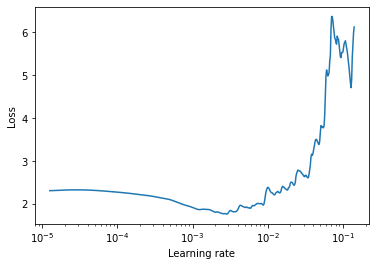

In [10]:
lrfinder.plot()


In [0]:
Best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]

In [0]:
lrfinder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
scheduler = ReduceLROnPlateau(optimizer, patience = 6, min_lr=1e-4)

In [14]:
testLoss = []
testAcc = []
EPOCHS = 50
#best_acc1 = 10
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(resnet, device, criterion, testloader)
     scheduler.step(test_loss[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0028729848333536637


Loss=1.2602427005767822 Batch_id=390 Accuracy=42.37: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 5461/10000 (54.61%)

EPOCH: 2 LR: 0.0028729848333536637


Loss=1.1230980157852173 Batch_id=390 Accuracy=56.31: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6635/10000 (66.35%)

EPOCH: 3 LR: 0.0028729848333536637


Loss=0.9925557971000671 Batch_id=390 Accuracy=62.36: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 6753/10000 (67.53%)

EPOCH: 4 LR: 0.0028729848333536637


Loss=0.7950026392936707 Batch_id=390 Accuracy=66.84: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7169/10000 (71.69%)

EPOCH: 5 LR: 0.0028729848333536637


Loss=0.9131399989128113 Batch_id=390 Accuracy=69.90: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7368/10000 (73.68%)

EPOCH: 6 LR: 0.0028729848333536637


Loss=0.667711615562439 Batch_id=390 Accuracy=72.41: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7836/10000 (78.36%)

EPOCH: 7 LR: 0.0028729848333536637


Loss=0.6531484723091125 Batch_id=390 Accuracy=74.41: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7948/10000 (79.48%)

EPOCH: 8 LR: 0.0028729848333536637


Loss=0.7696112394332886 Batch_id=390 Accuracy=75.44: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8132/10000 (81.32%)

EPOCH: 9 LR: 0.0028729848333536637


Loss=0.5908534526824951 Batch_id=390 Accuracy=76.81: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8194/10000 (81.94%)

EPOCH: 10 LR: 0.0028729848333536637


Loss=0.6186202764511108 Batch_id=390 Accuracy=78.08: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8169/10000 (81.69%)

EPOCH: 11 LR: 0.0028729848333536637


Loss=0.6389409303665161 Batch_id=390 Accuracy=79.13: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8210/10000 (82.10%)

EPOCH: 12 LR: 0.0028729848333536637


Loss=0.5684036016464233 Batch_id=390 Accuracy=79.88: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8189/10000 (81.89%)

EPOCH: 13 LR: 0.0028729848333536637


Loss=0.6595667600631714 Batch_id=390 Accuracy=80.43: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8374/10000 (83.74%)

EPOCH: 14 LR: 0.0028729848333536637


Loss=0.5258680582046509 Batch_id=390 Accuracy=81.47: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8561/10000 (85.61%)

EPOCH: 15 LR: 0.0028729848333536637


Loss=0.5744541883468628 Batch_id=390 Accuracy=81.87: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8474/10000 (84.74%)

EPOCH: 16 LR: 0.0028729848333536637


Loss=0.4979422986507416 Batch_id=390 Accuracy=82.59: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8572/10000 (85.72%)

EPOCH: 17 LR: 0.0028729848333536637


Loss=0.44939059019088745 Batch_id=390 Accuracy=83.24: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8568/10000 (85.68%)

EPOCH: 18 LR: 0.0028729848333536637


Loss=0.3796707093715668 Batch_id=390 Accuracy=83.76: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8490/10000 (84.90%)

EPOCH: 19 LR: 0.0028729848333536637


Loss=0.43986043334007263 Batch_id=390 Accuracy=84.19: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8406/10000 (84.06%)

EPOCH: 20 LR: 0.0028729848333536637


Loss=0.42877793312072754 Batch_id=390 Accuracy=84.72: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8711/10000 (87.11%)

EPOCH: 21 LR: 0.0028729848333536637


Loss=0.3237490653991699 Batch_id=390 Accuracy=85.18: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8656/10000 (86.56%)

EPOCH: 22 LR: 0.0028729848333536637


Loss=0.38379818201065063 Batch_id=390 Accuracy=85.38: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8681/10000 (86.81%)

EPOCH: 23 LR: 0.0028729848333536637


Loss=0.26602888107299805 Batch_id=390 Accuracy=85.77: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8633/10000 (86.33%)

EPOCH: 24 LR: 0.0028729848333536637


Loss=0.4815015196800232 Batch_id=390 Accuracy=86.50: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8660/10000 (86.60%)

EPOCH: 25 LR: 0.0028729848333536637


Loss=0.45629438757896423 Batch_id=390 Accuracy=86.60: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8673/10000 (86.73%)

EPOCH: 26 LR: 0.0028729848333536637


Loss=0.3208189904689789 Batch_id=390 Accuracy=86.84: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8732/10000 (87.32%)

EPOCH: 27 LR: 0.0028729848333536637


Loss=0.4214105010032654 Batch_id=390 Accuracy=87.23: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8803/10000 (88.03%)

EPOCH: 28 LR: 0.0028729848333536637


Loss=0.20932140946388245 Batch_id=390 Accuracy=87.76: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8737/10000 (87.37%)

EPOCH: 29 LR: 0.0028729848333536637


Loss=0.39734482765197754 Batch_id=390 Accuracy=87.85: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8829/10000 (88.29%)

EPOCH: 30 LR: 0.0028729848333536637


Loss=0.41802793741226196 Batch_id=390 Accuracy=88.24: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8820/10000 (88.20%)

EPOCH: 31 LR: 0.0028729848333536637


Loss=0.3305801749229431 Batch_id=390 Accuracy=88.36: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8805/10000 (88.05%)

EPOCH: 32 LR: 0.0028729848333536637


Loss=0.4186496138572693 Batch_id=390 Accuracy=88.53: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8763/10000 (87.63%)

EPOCH: 33 LR: 0.0028729848333536637


Loss=0.23709604144096375 Batch_id=390 Accuracy=88.89: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8862/10000 (88.62%)

EPOCH: 34 LR: 0.0028729848333536637


Loss=0.38902753591537476 Batch_id=390 Accuracy=89.17: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8735/10000 (87.35%)

EPOCH: 35 LR: 0.0028729848333536637


Loss=0.5483372807502747 Batch_id=390 Accuracy=89.34: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8604/10000 (86.04%)

EPOCH: 36 LR: 0.0028729848333536637


Loss=0.25908464193344116 Batch_id=390 Accuracy=89.30: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8994/10000 (89.94%)

EPOCH: 37 LR: 0.0028729848333536637


Loss=0.3264544606208801 Batch_id=390 Accuracy=89.99: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8948/10000 (89.48%)

EPOCH: 38 LR: 0.0028729848333536637


Loss=0.34139978885650635 Batch_id=390 Accuracy=89.72: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8937/10000 (89.37%)

EPOCH: 39 LR: 0.0028729848333536637


Loss=0.30204400420188904 Batch_id=390 Accuracy=90.08: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8828/10000 (88.28%)

EPOCH: 40 LR: 0.0028729848333536637


Loss=0.22821256518363953 Batch_id=390 Accuracy=90.51: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8913/10000 (89.13%)

EPOCH: 41 LR: 0.0028729848333536637


Loss=0.28875917196273804 Batch_id=390 Accuracy=90.59: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8858/10000 (88.58%)

EPOCH: 42 LR: 0.0028729848333536637


Loss=0.19999024271965027 Batch_id=390 Accuracy=90.60: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8891/10000 (88.91%)

EPOCH: 43 LR: 0.0028729848333536637


Loss=0.26682212948799133 Batch_id=390 Accuracy=90.60: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8942/10000 (89.42%)

EPOCH: 44 LR: 0.00028729848333536637


Loss=0.24773192405700684 Batch_id=390 Accuracy=92.77: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9166/10000 (91.66%)

EPOCH: 45 LR: 0.00028729848333536637


Loss=0.2870703339576721 Batch_id=390 Accuracy=93.87: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9183/10000 (91.83%)

EPOCH: 46 LR: 0.00028729848333536637


Loss=0.18960899114608765 Batch_id=390 Accuracy=94.08: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 9176/10000 (91.76%)

EPOCH: 47 LR: 0.00028729848333536637


Loss=0.1660240739583969 Batch_id=390 Accuracy=94.17: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9188/10000 (91.88%)

EPOCH: 48 LR: 0.00028729848333536637


Loss=0.07876132428646088 Batch_id=390 Accuracy=94.38: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9195/10000 (91.95%)

EPOCH: 49 LR: 0.00028729848333536637


Loss=0.09464900195598602 Batch_id=390 Accuracy=94.46: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9188/10000 (91.88%)

EPOCH: 50 LR: 0.00028729848333536637


Loss=0.2138078212738037 Batch_id=390 Accuracy=94.65: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]



Test set: Average loss: 0.0021, Accuracy: 9186/10000 (91.86%)



In [15]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 91.860 %


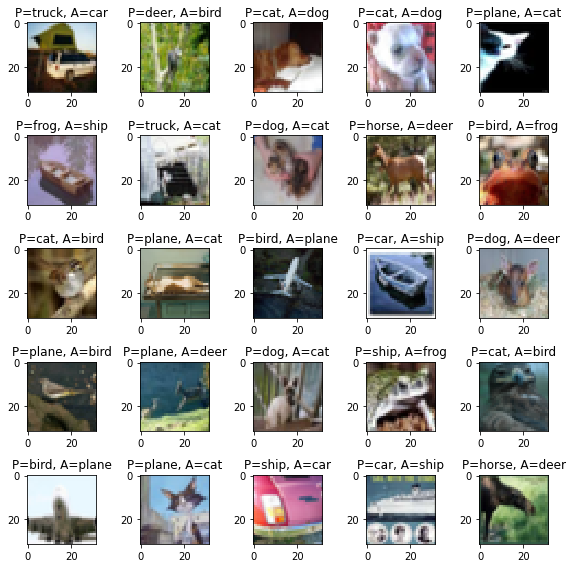

In [16]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [17]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 96 %
Accuracy of   car : 100 %
Accuracy of  bird : 94 %
Accuracy of   cat : 75 %
Accuracy of  deer : 89 %
Accuracy of   dog : 92 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %


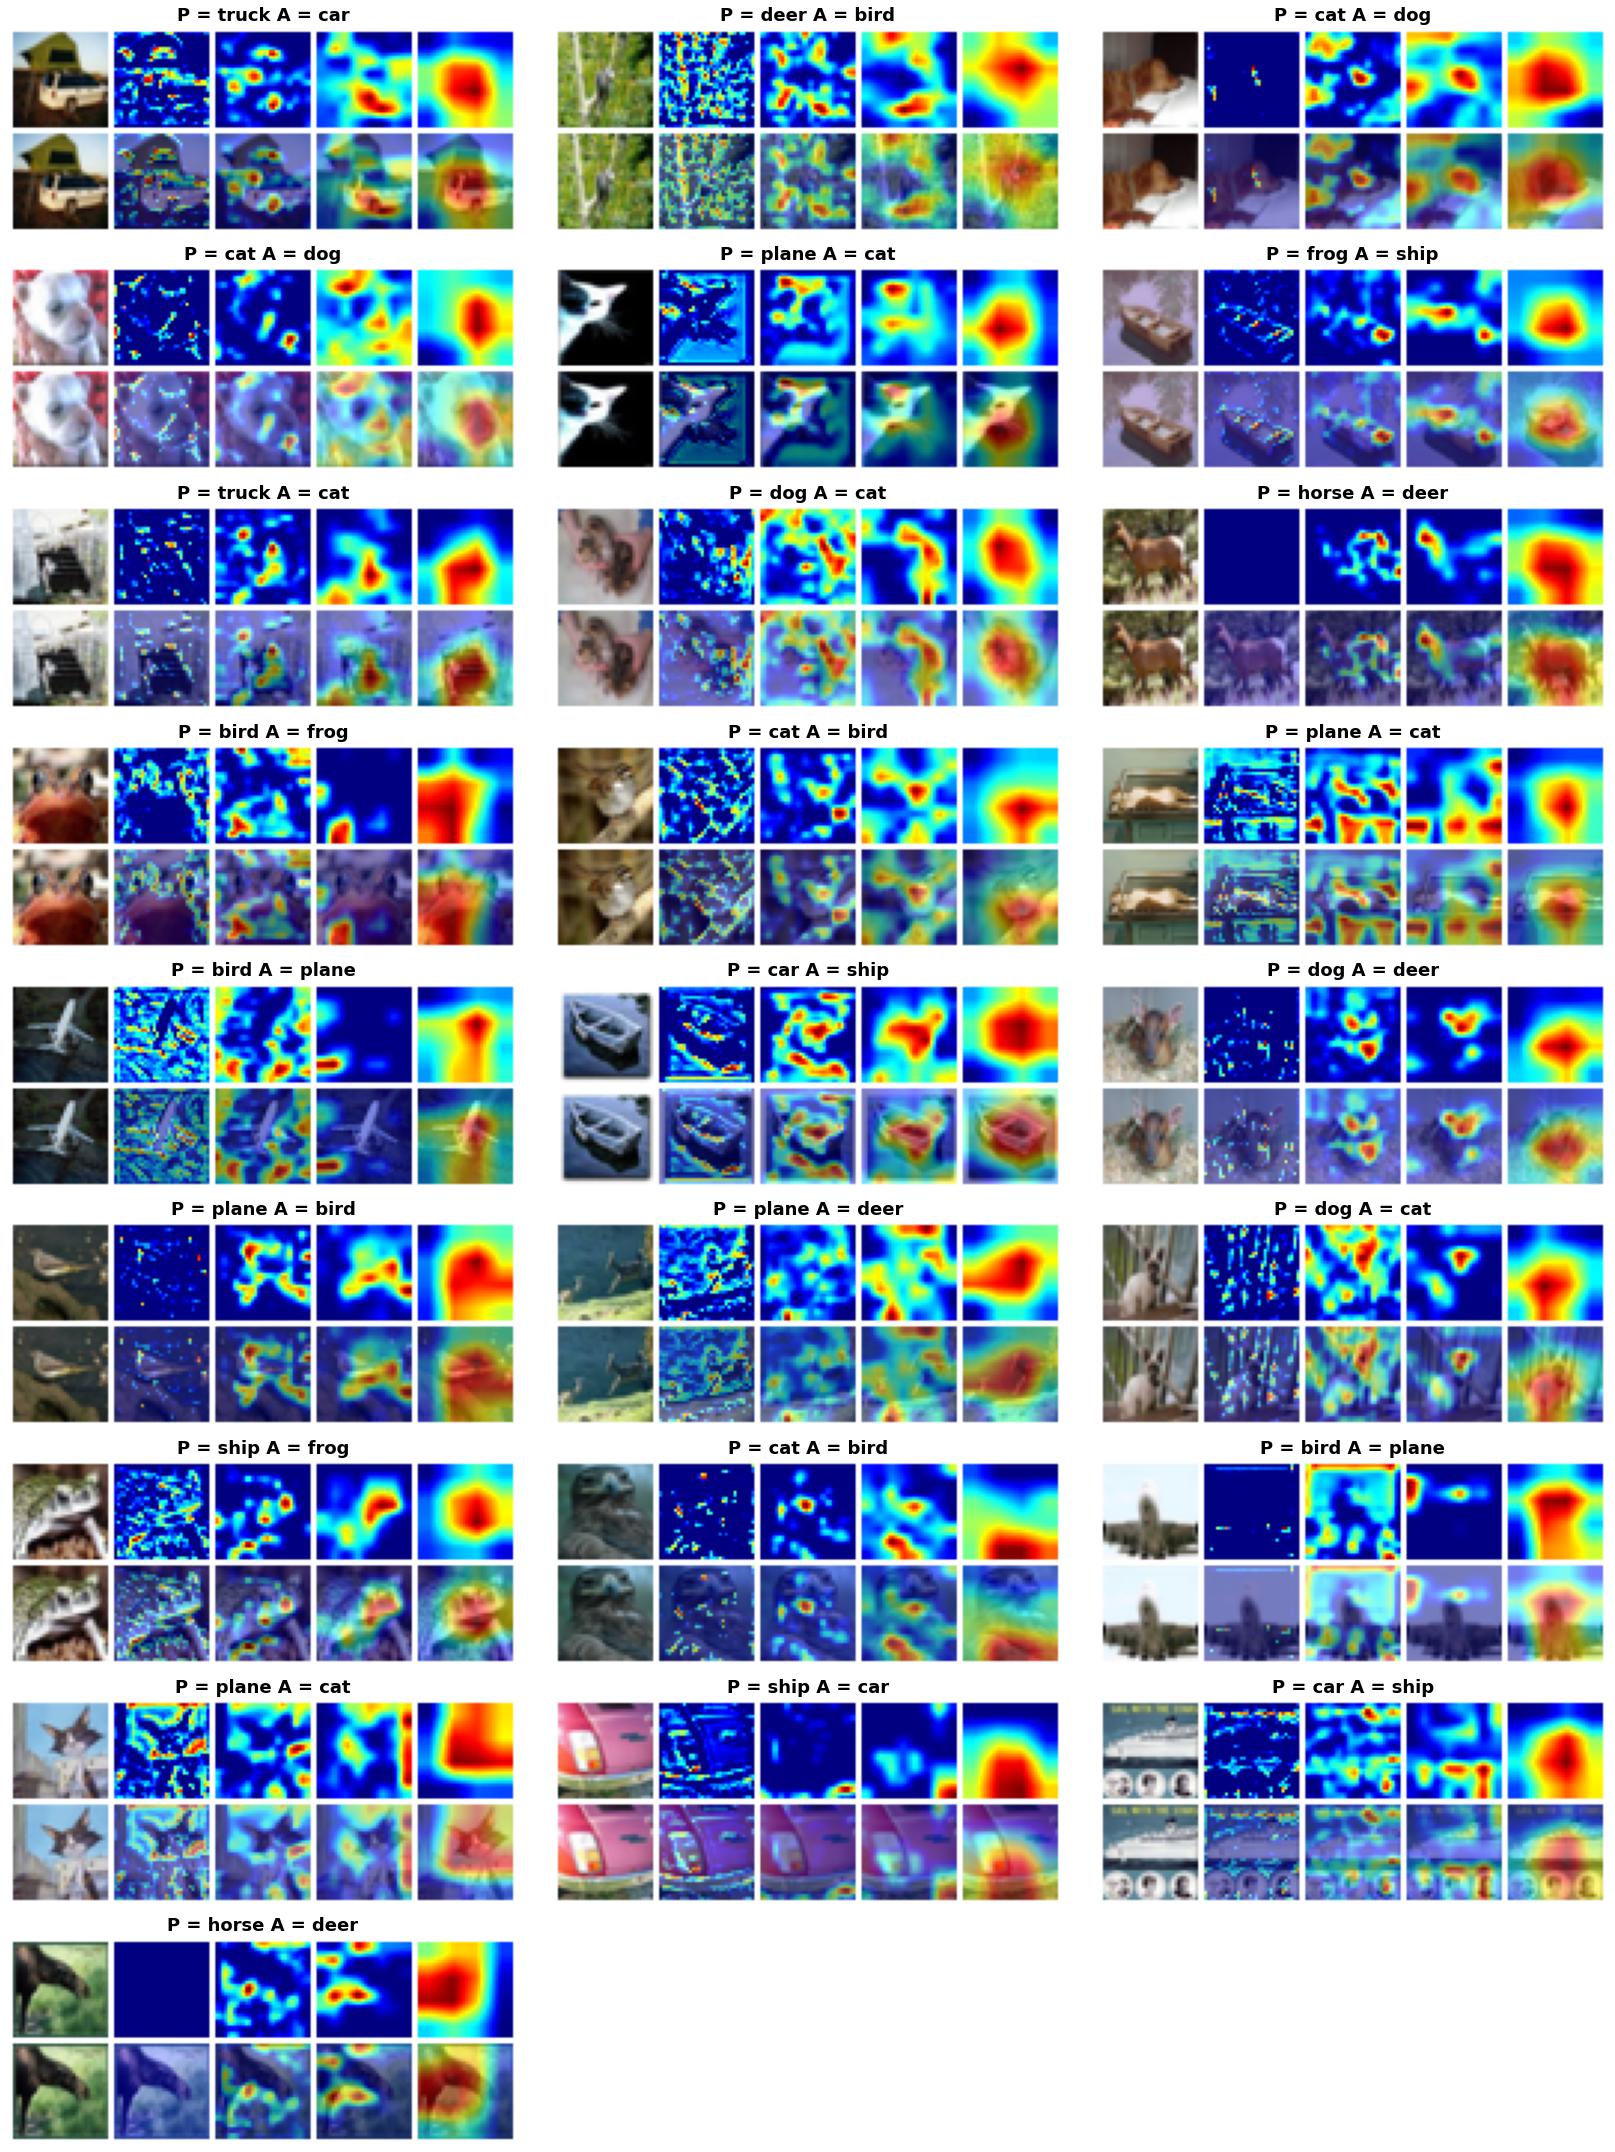

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = resnet.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [resnet.layer1,resnet.layer2,resnet.layer3,resnet.layer4]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)